Hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
Mean Squared Error for Unique Collection IDs: 0.5848111508491591
Mean Squared Error for Unique Machine IDs: 0.9343178132777488
Hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01}
Mean Squared Error for Unique Collection IDs: 8.182400597640077
Mean Squared Error for Unique Machine IDs: 11.3511002383473
Hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.05}
Mean Squared Error for Unique Collection IDs: 0.42857682186796037
Mean Squared Error for Unique Machine IDs: 0.7503339547408706


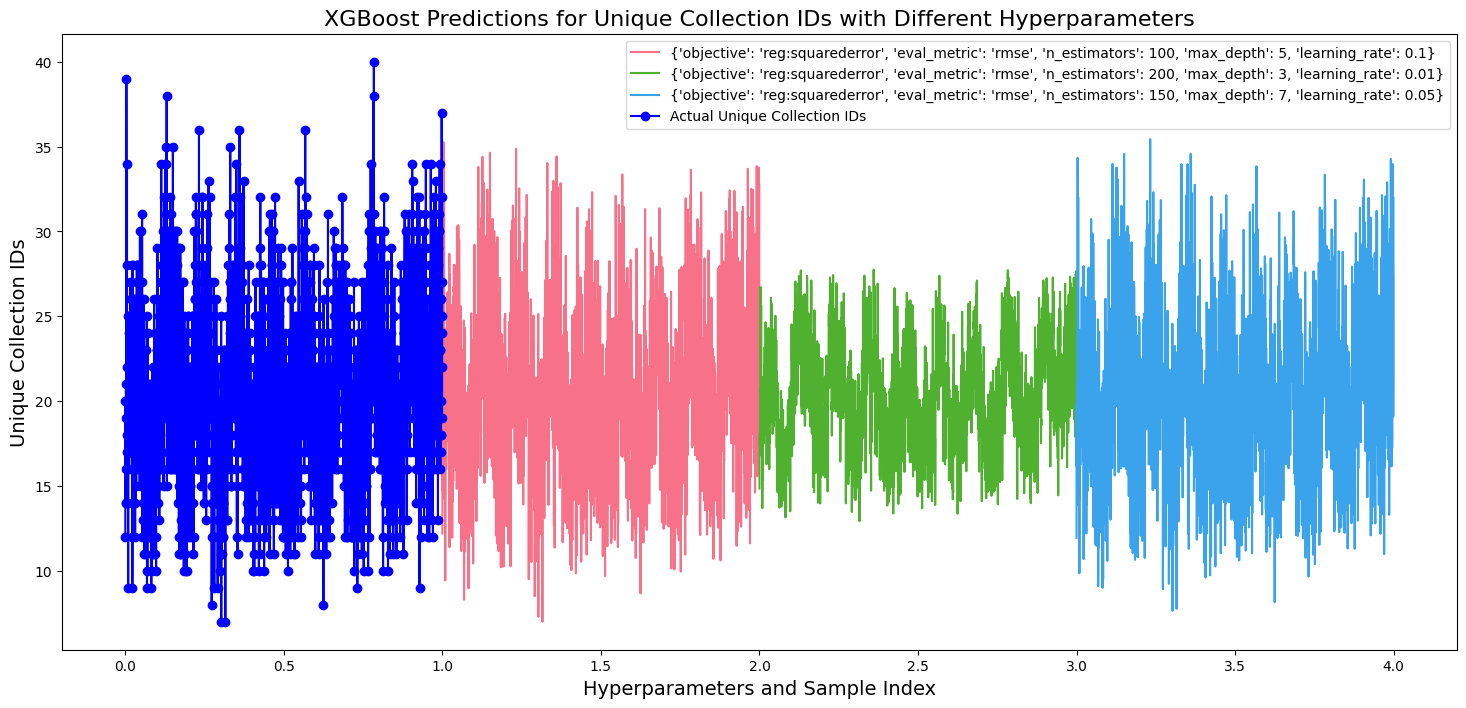

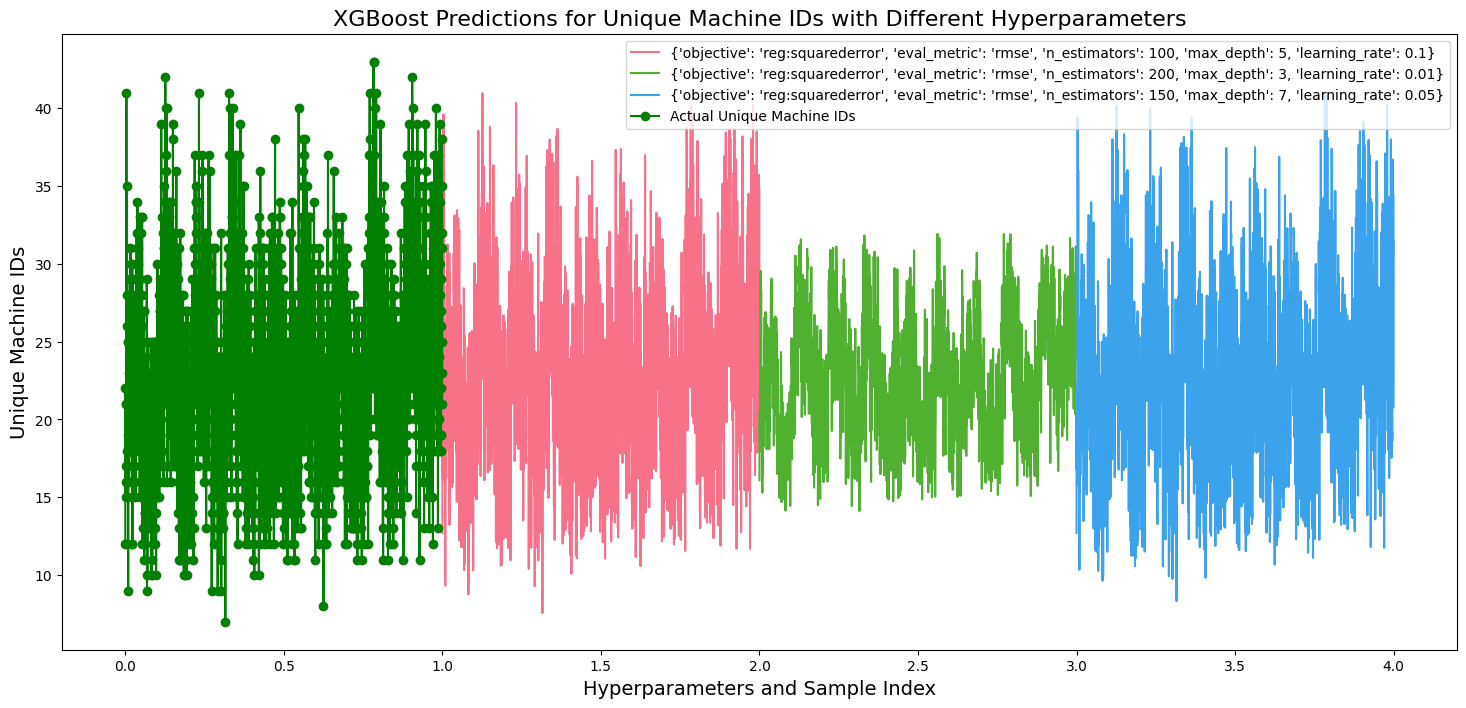

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset extracted from BigQuery
file_path = "/home/nsmsc/merged_instance_usage_200k - new.csv"
data = pd.read_csv(file_path)

# Convert start and end times from microseconds to seconds
data['start_time'] = data['start_time'] / 1e6
data['end_time'] = data['end_time'] / 1e6

# Sort data by start time
data = data.sort_values(by='start_time')

# Define the interval length 
interval_length = 300

def process_interval(interval_data):
    collection_id_counts = interval_data['collection_id'].value_counts()
    non_unique_collection_ids_count = collection_id_counts[collection_id_counts > 1].count()
    unique_collection_ids_count = interval_data['collection_id'].nunique()
    unique_machine_ids_count = interval_data['machine_id'].nunique()
    sum_avg_cpu = interval_data['average_usage.cpus'].sum()
    sum_avg_memory = interval_data['average_usage.memory'].sum()
    sum_max_cpu = interval_data['maximum_usage.cpus'].sum()
    sum_max_memory = interval_data['maximum_usage.memory'].sum()
    return {
        'unique_collection_ids': unique_collection_ids_count,
        'non_unique_collection_ids': non_unique_collection_ids_count,
        'unique_machine_ids': unique_machine_ids_count,
        'sum_avg_cpu': sum_avg_cpu,
        'sum_avg_memory': sum_avg_memory,
        'sum_max_cpu': sum_max_cpu,
        'sum_max_memory': sum_max_memory
    }

def prepare_features(data):
    results = []
    start_time = data['start_time'].min()
    end_time = data['start_time'].max()
    current_start = start_time

    while current_start < end_time:
        current_end = current_start + interval_length
        interval_data = data[(data['start_time'] >= current_start) & (data['start_time'] < current_end)]
        if not interval_data.empty:
            interval_result = process_interval(interval_data)
            interval_result['interval_start'] = current_start
            results.append(interval_result)
        current_start = current_end

    df = pd.DataFrame(results)
    
    # Add time-based features
    df['hour_of_day'] = (df['interval_start'] % 86400) // 3600
    df['day_of_week'] = (df['interval_start'] // 86400) % 7

    # Add lag features
    lag_features = ['unique_collection_ids', 'non_unique_collection_ids', 'unique_machine_ids', 'sum_avg_cpu', 'sum_avg_memory', 'sum_max_cpu', 'sum_max_memory']
    for feature in lag_features:
        for lag in range(1, 4):
            df[f'{feature}_lag{lag}'] = df[feature].shift(lag)
    
    # Add rolling statistics
    for feature in lag_features:
        df[f'{feature}_rolling_mean'] = df[feature].rolling(window=3).mean()
        df[f'{feature}_rolling_std'] = df[feature].rolling(window=3).std()

    # Drop rows with NaN values created by shifting
    df = df.dropna().reset_index(drop=True)
    
    return df

# Split the data into 70% training and 30% testing
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)


train_features = prepare_features(train_data)


test_features = prepare_features(test_data)

# Define features and labels for both targets
X_train = train_features.drop(columns=['unique_collection_ids', 'non_unique_collection_ids', 'unique_machine_ids'])
y_train_collection_ids = train_features[['unique_collection_ids']]
y_train_machine_ids = train_features[['unique_machine_ids']]

# Hyperparameter sets for XGBoost
param_sets = [
    {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1},
    {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01},
    {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.05}
]


results = []
for params in param_sets:
    # Initialize XGBoost models with current hyperparameters
    model_collection_ids = xgb.XGBRegressor(**params)
    model_machine_ids = xgb.XGBRegressor(**params)
    
    # Train the models
    model_collection_ids.fit(X_train, y_train_collection_ids)
    model_machine_ids.fit(X_train, y_train_machine_ids)
    

    X_test = test_features.drop(columns=['unique_collection_ids', 'non_unique_collection_ids', 'unique_machine_ids'])
    y_test_collection_ids = test_features[['unique_collection_ids']]
    y_test_machine_ids = test_features[['unique_machine_ids']]
    

    y_pred_collection_ids = model_collection_ids.predict(X_test)
    y_pred_machine_ids = model_machine_ids.predict(X_test)
    
  
    mse_collection_ids = mean_squared_error(y_test_collection_ids, y_pred_collection_ids)
    mse_machine_ids = mean_squared_error(y_test_machine_ids, y_pred_machine_ids)
    
    print(f"Hyperparameters: {params}")
    print(f"Mean Squared Error for Unique Collection IDs: {mse_collection_ids}")
    print(f"Mean Squared Error for Unique Machine IDs: {mse_machine_ids}")
    

    pred_df_collection_ids = pd.DataFrame(y_pred_collection_ids, columns=['unique_collection_ids_pred'])
    pred_df_machine_ids = pd.DataFrame(y_pred_machine_ids, columns=['unique_machine_ids_pred'])
    
    result_df = pd.concat([test_features.reset_index(drop=True), pred_df_collection_ids, pred_df_machine_ids], axis=1)
    results.append({
        'params': params,
        'mse_collection_ids': mse_collection_ids,
        'mse_machine_ids': mse_machine_ids,
        'result_df': result_df
    })


plot_data = pd.DataFrame({
    'Parameter': np.concatenate([[str(result['params'])] * len(result['result_df']) for result in results]),
    'Unique Collection IDs': np.concatenate([result['result_df']['unique_collection_ids_pred'] for result in results]),
    'Unique Machine IDs': np.concatenate([result['result_df']['unique_machine_ids_pred'] for result in results]),
    'Sample Index': np.concatenate([result['result_df'].index for result in results])
})


plot_data['X'] = plot_data['Parameter'].map({str(param_sets[i]): i + 1 for i in range(len(param_sets))}) + plot_data['Sample Index'] / len(test_features)

# Plot Unique Collection IDs
plt.figure(figsize=(18, 8))
sns.lineplot(data=plot_data, x='X', y='Unique Collection IDs', hue='Parameter', palette='husl')

# Plot actual values 
plt.plot(test_features.index / len(test_features), test_features['unique_collection_ids'], marker='o', color='blue', label='Actual Unique Collection IDs')


plt.title('XGBoost Predictions for Unique Collection IDs with Different Hyperparameters', fontsize=16)
plt.xlabel('Hyperparameters and Sample Index', fontsize=14)
plt.ylabel('Unique Collection IDs', fontsize=14)
plt.legend()
plt.show()

# Plot Unique Machine IDs
plt.figure(figsize=(18, 8))
sns.lineplot(data=plot_data, x='X', y='Unique Machine IDs', hue='Parameter', palette='husl')

# Plot actual values 
plt.plot(test_features.index / len(test_features), test_features['unique_machine_ids'], marker='o', color='green', label='Actual Unique Machine IDs')


plt.title('XGBoost Predictions for Unique Machine IDs with Different Hyperparameters', fontsize=16)
plt.xlabel('Hyperparameters and Sample Index', fontsize=14)
plt.ylabel('Unique Machine IDs', fontsize=14)
plt.legend()
plt.show()
